# Proyecto Cancer Bucal

## Librerias

In [1]:
##Librerias
import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Contar Imagenes Procesadas

In [2]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

path = r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Preprocesadas';
DatasetSize = GetDatasetSize(path);
print(DatasetSize);

{'cancer': 500, 'non-cancer': 450}


## División de Datos 

70% Datos Entrenamiento
15% Datos Validación
15% Datos Testeo

In [3]:

def TrainValTestSplit(root_dir, classes_dir, val_ratio=0.15, test_ratio=0.15):
    for cls in classes_dir:
        train_path = os.path.join(r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Entrenamiento', cls)
        val_path = os.path.join(r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Validacion', cls)
        test_path = os.path.join(r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Testeo', cls)

        os.makedirs(train_path, exist_ok=True)
        os.makedirs(val_path, exist_ok=True)
        os.makedirs(test_path, exist_ok=True)

        src = os.path.join(root_dir, cls)

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames) * (1 - (val_ratio + test_ratio))), int(len(allFileNames) * (1 - test_ratio))])

        train_FileNames = [os.path.join(src, name) for name in train_FileNames.tolist()]
        val_FileNames = [os.path.join(src, name) for name in val_FileNames.tolist()]
        test_FileNames = [os.path.join(src, name) for name in test_FileNames.tolist()]

        print(cls.upper(), ':')
        print('Total Imagenes: ', len(allFileNames))
        print('Entrenamiento: ', len(train_FileNames))
        print('Validación: ', len(val_FileNames))
        print('Testeo: ', len(test_FileNames))

        for name in train_FileNames:
            shutil.copy(name, train_path)

        for name in val_FileNames:
            shutil.copy(name, val_path)

        for name in test_FileNames:
            shutil.copy(name, test_path)
        print()

root_dir = r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Procesadas'
classes_dir = ['cancer', 'non-cancer']  # Classes
TrainValTestSplit(root_dir, classes_dir)


CANCER :
Total Imagenes:  464
Entrenamiento:  324
Validación:  70
Testeo:  70

NON-CANCER :
Total Imagenes:  435
Entrenamiento:  304
Validación:  65
Testeo:  66



# Construcción Modelos

## DenseNet - 201

In [4]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
import numpy as np

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives + false_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_negatives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_positives / (true_positives + false_negatives + K.epsilon())

modelo_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in modelo_DenseNet201.layers:
    layer.trainable = False

def crea_modelo_DenseNet201(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  
    predictions = Dense(1, activation='sigmoid')(x)

    modelo_combinado_DenseNet201 = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.0001)  # Ajusta la tasa de aprendizaje
    modelo_combinado_DenseNet201.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', specificity, sensitivity])

    return modelo_combinado_DenseNet201

densenet_201 = crea_modelo_DenseNet201(modelo_DenseNet201)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Entrenamiento', target_size=(256,256), batch_size=32, class_mode='binary')
val_data = val_datagen.flow_from_directory(directory=r'C:\Users\enavarro\Desktop\Eduardo\Proyecto_Bucal\DataSet\DataSet_Kaagle_2.0\Division_Datos\Validacion', target_size=(256,256), batch_size=32, class_mode='binary')

checkpoint_callback = ModelCheckpoint(filepath="pt_control_modelo.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

densenet201 = densenet_201.fit(
    train_data,
    steps_per_epoch=2,
    epochs=200,
    validation_data=val_data,
    validation_steps=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

y_true = val_data.labels
y_pred = densenet_201.predict(val_data)
val_loss, val_accuracy, val_specificity, val_sensitivity = densenet_201.evaluate(val_data)
print(f"Loss: {val_loss}, Accuracy: {val_accuracy}, Specificity: {val_specificity}, Sensitivity: {val_sensitivity}")


Found 899 images belonging to 2 classes.
Found 889 images belonging to 2 classes.
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5703 - loss: 0.7442 - sensitivity: 0.4531 - specificity: 0.8516  
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to pt_control_modelo.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 15s/step - accuracy: 0.5625 - loss: 0.7451 - sensitivity: 0.4583 - specificity: 0.8333 - val_accuracy: 0.6250 - val_loss: 0.6307 - val_sensitivity: 0.3438 - val_specificity: 0.4688
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5078 - loss: 0.8085 - sensitivity: 0.5938 - specificity: 0.4297
Epoch 2: val_accuracy did not improve from 0.62500
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5104 - loss: 0.8008 - sensitivity: 0.5833 - specificity: 0.4271 - val_accuracy: 0.5938 - val_loss: 0.6503 - val_sensitivity: 0.5312 - val_specificity: 0.1250
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5781 - loss: 0.7383 - sensitivity: 0.51

In [5]:
print(f"Accuracy DenseNet201 = {val_accuracy * 100} %")
print(f"Perdida DenseNet201 = {val_loss * 100} %")
print(f"Especificidad DenseNet201 = {val_specificity * 100} %")
print(f"Sensibilidad DenseNet201 = {val_sensitivity * 100} %")

Accuracy DenseNet201 = 84.36445593833923 %
Perdida DenseNet201 = 34.36439037322998 %
Especificidad DenseNet201 = 62.33035326004028 %
Sensibilidad DenseNet201 = 48.303571343421936 %


In [6]:

# Ajuste fino de algunas capas superiores del modelo
for layer in densenet_201.layers[-20:]:
    layer.trainable = True

# Compila nuevamente el modelo para el ajuste fino
densenet_201.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', specificity, sensitivity])

# Entrena nuevamente el modelo con el ajuste fino
densenet201_fine_tuned = densenet_201.fit(
    train_data,
    steps_per_epoch=2,
    epochs=50,  # Número de épocas para el ajuste fino
    validation_data=val_data,
    validation_steps=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7188 - loss: 0.6218 - sensitivity: 0.5703 - specificity: 0.6641  
Epoch 1: val_accuracy did not improve from 0.93750
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 15s/step - accuracy: 0.7292 - loss: 0.6138 - sensitivity: 0.5833 - specificity: 0.6458 - val_accuracy: 0.8750 - val_loss: 0.3979 - val_sensitivity: 0.4062 - val_specificity: 0.4688
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9375 - loss: 0.3095 - sensitivity: 0.5703 - specificity: 0.4141
Epoch 2: val_accuracy did not improve from 0.93750
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.9271 - loss: 0.3244 - sensitivity: 0.5625 - specificity: 0.4062 - val_accuracy: 0.8125 - val_loss: 0.3421 - val_sensitivity: 0.5625 - val_specificity: 0.2500
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6875 - loss: 0.5732 - sensitivity: 0.4062 - specificity: 0.2969
Epoch 3: val_accuracy did not improve from 0.93750
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.

# TABLA RESUMEN

In [7]:
print(f"Accuracy DenseNet201 = {val_accuracy * 100} %")
print(f"Perdida DenseNet201 = {val_loss * 100} %")
print(f"Especificidad DenseNet201 = {val_specificity * 100} %")
print(f"Sensibilidad DenseNet201 = {val_sensitivity * 100} %")

Accuracy DenseNet201 = 84.36445593833923 %
Perdida DenseNet201 = 34.36439037322998 %
Especificidad DenseNet201 = 62.33035326004028 %
Sensibilidad DenseNet201 = 48.303571343421936 %


# Graficos DenseNet 201

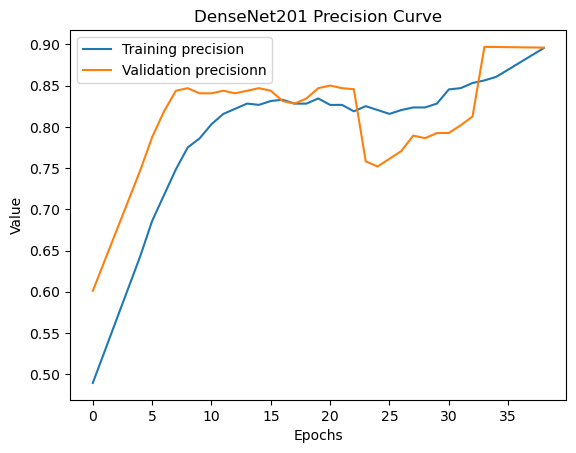

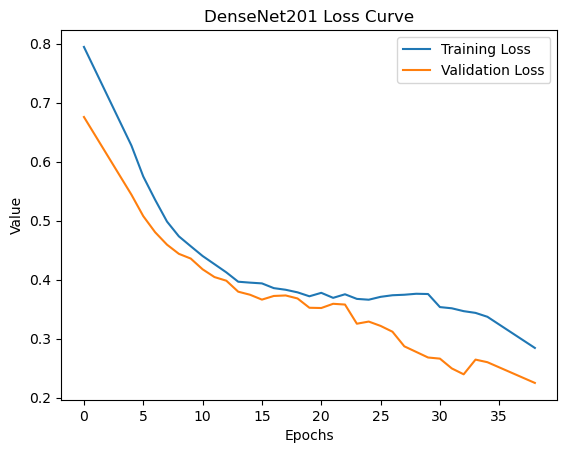

In [8]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

training_accuracy_densenet201 = densenet201.history['accuracy']
training_loss_densenet201 = densenet201.history['loss']
validation_accuracy_densenet201 = densenet201.history['val_accuracy']
validation_loss_densenet201 = densenet201.history['val_loss']

smoothed_training_accuracy201 = savgol_filter(training_accuracy_densenet201, window_length=10, polyorder=1)
smoothed_training_loss201 = savgol_filter(training_loss_densenet201, window_length=10, polyorder=1)
smoothed_validation_accuracy201 = savgol_filter(validation_accuracy_densenet201, window_length=10, polyorder=1)
smoothed_validation_loss201 = savgol_filter(validation_loss_densenet201, window_length=10, polyorder=1)

plt.plot(smoothed_training_accuracy201, label='Training precision')
plt.plot(smoothed_validation_accuracy201, label='Validation precisionn')
plt.title('DenseNet201 Precision Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(smoothed_training_loss201, label='Training Loss')
plt.plot(smoothed_validation_loss201, label='Validation Loss')
plt.title('DenseNet201 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


In [9]:
# Guardar Modelo Entrenado con mejor desempeño
densenet_201.save("Modelo_201.h5")